## Importaciones y configuración inicial

En esta sección se cargan las librerías necesarias para el modelado, procesamiento de datos y visualización.
Se configura también el dispositivo de cómputo (CPU o GPU) y algunos parámetros generales.

El modelo LSTM se implementará en **PyTorch**, utilizando `DataLoader` para manejar las secuencias temporales.


In [17]:
# === Importaciones y configuración inicial ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

# Configurar dispositivo
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device} | CPU threads: {torch.get_num_threads()}")


RuntimeError: Error: cannot set number of interop threads after parallel work has started or set_num_interop_threads called

## Carga y exploración del dataset

Se carga el conjunto de datos sincronizado `ruido_cuenca_sync.csv`, que contiene los registros de ruido en diferentes puntos de la ciudad.  
El objetivo es preparar estos datos para ser utilizados en la red LSTM.

En este paso se:
- Lee el archivo CSV.
- Convierte la columna temporal a formato `datetime`.
- Ordena los datos cronológicamente.


In [18]:
# === Carga y exploración del dataset ===
data_path = "../../data/clean/ruido_cuenca_sync.csv"
df = pd.read_csv(data_path)

print("Forma del dataset:", df.shape)
display(df.head())
print(df.columns)

# Convertir columna temporal
if "timestamp" in df.columns or "Unnamed: 0" in df.columns:
    col_ts = "timestamp" if "timestamp" in df.columns else "Unnamed: 0"
    df = df.rename(columns={col_ts: "timestamp"})
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)


Forma del dataset: (249119, 9)


,Unnamed: 0,ruido_SCP01,ruido_SCP06,ruido_SCP07,ruido_SCP08,ruido_SCP09,ruido_SCP13,ruido_SCP16,ruido_SCP17
0,2025-04-16 00:01:00,41.920000,57.83,59.58,68.250000,75.68,64.780,67.27,67.7
1,2025-04-16 00:02:00,41.931818,57.83,59.58,68.250000,75.68,64.780,67.27,67.7
2,2025-04-16 00:03:00,41.943636,57.83,59.58,68.250000,75.68,64.780,67.27,67.7
3,2025-04-16 00:04:00,41.955455,57.83,59.58,67.742727,75.68,64.780,67.27,67.7
4,2025-04-16 00:05:00,41.967273,57.83,59.58,67.235455,75.68,64.806,67.27,67.7


Index(['Unnamed: 0', 'ruido_SCP01', 'ruido_SCP06', 'ruido_SCP07',
       'ruido_SCP08', 'ruido_SCP09', 'ruido_SCP13', 'ruido_SCP16',
       'ruido_SCP17'],
      dtype='object')


## Preparación de las secuencias temporales

El modelo LSTM requiere entradas con estructura **(muestras, pasos de tiempo, características)**.

En esta sección se:
- Seleccionan las variables numéricas relevantes.
- Normalizan los valores con `MinMaxScaler`.
- Crean las secuencias temporales (ventanas deslizantes).
- Dividen los datos en conjuntos de entrenamiento y prueba.


In [19]:
# === Preparación de los datos para LSTM ===
sensor_cols = [c for c in df.columns if c.startswith("ruido_")]
assert len(sensor_cols) > 0, "No se encontraron columnas 'ruido_'"

TARGET = "ruido_SCP01"
feat_cols = [TARGET] + [c for c in sensor_cols if c != TARGET]

data_np = df[feat_cols].to_numpy(dtype="float32")

split_idx = int(0.8 * len(data_np))
train_raw, test_raw = data_np[:split_idx], data_np[split_idx:]

scaler_y, scaler_X = MinMaxScaler(), MinMaxScaler()

y_train, X_train = train_raw[:, [0]], train_raw[:, 1:]
y_test, X_test   = test_raw[:, [0]], test_raw[:, 1:]

scaler_y.fit(y_train)
scaler_X.fit(X_train)

train_scaled = np.concatenate(
    [scaler_y.transform(y_train), scaler_X.transform(X_train)], axis=1
)
test_scaled = np.concatenate(
    [scaler_y.transform(y_test), scaler_X.transform(X_test)], axis=1
)

print("Train/Test:", train_scaled.shape, test_scaled.shape)


Train/Test: (199295, 8) (49824, 8)


In [20]:
# === Crear secuencias para el modelo LSTM ===
def create_sequences(arr, seq_len=24, step=1):
    Xs, ys = [], []
    for i in range(0, len(arr) - seq_len, step):
        Xs.append(arr[i:i+seq_len])
        ys.append(arr[i+seq_len, 0])  # primera col = target
    return torch.tensor(np.stack(Xs), dtype=torch.float32), torch.tensor(np.stack(ys), dtype=torch.float32)

SEQ_LEN, STRIDE = 24, 1
X_tr, y_tr = create_sequences(train_scaled, SEQ_LEN, STRIDE)
X_te, y_te = create_sequences(test_scaled,  SEQ_LEN, STRIDE)

batch_size = 128
num_workers = max(1, os.cpu_count() - 1)

train_loader = DataLoader(
    TensorDataset(X_tr, y_tr),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,
    persistent_workers=True
)
test_loader = DataLoader(
    TensorDataset(X_te, y_te),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    persistent_workers=True
)

print(f"DataLoader configurado con batch_size={batch_size}, num_workers={num_workers}")


DataLoader configurado con batch_size=128, num_workers=15


## Definición del modelo LSTM

Aquí se implementa el modelo LSTM en PyTorch.  
El modelo cuenta con:
- Capas recurrentes para capturar dependencias temporales.
- Capas densas finales para predecir el nivel de ruido.

Estructura básica:
- Entrada: secuencias de características normalizadas.
- Salida: valor de ruido esperado para el siguiente instante.


In [ ]:
# === Definición del modelo LSTM ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_size = X_tr.shape[2]
model = LSTMModel(input_size=input_size).to(device)
print(model)


LSTMModel(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## Entrenamiento del modelo

Se entrena el modelo LSTM utilizando el conjunto de entrenamiento.  
El proceso incluye:
- Forward y backward pass por época.
- Optimización con Adam.
- Cálculo del error cuadrático medio (MSE) como función de pérdida.

Durante el entrenamiento, se registra la pérdida tanto de entrenamiento como de validación para analizar la convergencia.


In [7]:
from tqdm.auto import tqdm

# Definir criterio de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hiperparámetros
num_epochs = 5      # 🚀 Solo 5 épocas
patience = 2        # early stopping rápido
best_val = float("inf")
wait = 0

train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    # Barra de progreso durante entrenamiento
    pbar = tqdm(train_loader, desc=f"Época {epoch+1}/{num_epochs}", leave=False)
    
    for Xb, yb in pbar:
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    # Promedio de pérdida de entrenamiento
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # === Validación ===
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xv, yv in test_loader:
            Xv, yv = Xv.to(device), yv.to(device).unsqueeze(1)
            pv = model(Xv)
            val_loss += criterion(pv, yv).item()
    val_loss /= len(test_loader)
    test_losses.append(val_loss)
    
    print(f"Época [{epoch+1}/{num_epochs}] 🧠 Train: {train_loss:.6f} | Val: {val_loss:.6f}")
    
    # === Early Stopping y guardado ===
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        wait = 0
        torch.save(model.state_dict(), "lstm_best.pt")
        print(f"✅ Mejor modelo actualizado (val_loss={val_loss:.6f})")
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹️ Early stopping en época {epoch+1} (sin mejora en {patience} épocas)")
            break
    
    # Guardar checkpoint cada 2 épocas
    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pt")


Época [1/5] 🧠 Train: 0.002146 | Val: 0.000171
✅ Mejor modelo actualizado (val_loss=0.000171)


Época [2/5] 🧠 Train: 0.000179 | Val: 0.000121
✅ Mejor modelo actualizado (val_loss=0.000121)


Época [3/5] 🧠 Train: 0.000116 | Val: 0.000054
✅ Mejor modelo actualizado (val_loss=0.000054)


Época [4/5] 🧠 Train: 0.000082 | Val: 0.000033
✅ Mejor modelo actualizado (val_loss=0.000033)


Época [5/5] 🧠 Train: 0.000070 | Val: 0.000028
✅ Mejor modelo actualizado (val_loss=0.000028)


## Evaluación y visualización de resultados

Se evalúa el desempeño del modelo sobre el conjunto de prueba.

Métricas utilizadas:
- **RMSE (Root Mean Square Error)**: mide la desviación media de las predicciones.
- **MAE (Mean Absolute Error)**: mide el error promedio absoluto.
- **R² (Coeficiente de determinación)**: indica qué tan bien el modelo explica la variabilidad de los datos.

También se desnormalizan las predicciones para interpretarlas en unidades reales (dB).


===== Métricas de Test (escala real) =====
MSE : 0.017234
RMSE: 0.131277
MAE : 0.080727
R²  : 0.998969
✅ Predicciones guardadas en predicciones_test.csv


,timestamp,y_true,y_pred
0,2025-09-01 10:00:00,51.203533,51.271706
1,2025-09-01 10:01:00,51.203465,51.268707
2,2025-09-01 10:02:00,51.203407,51.270256
3,2025-09-01 10:03:00,51.203346,51.269924
4,2025-09-01 10:04:00,51.203281,51.266228


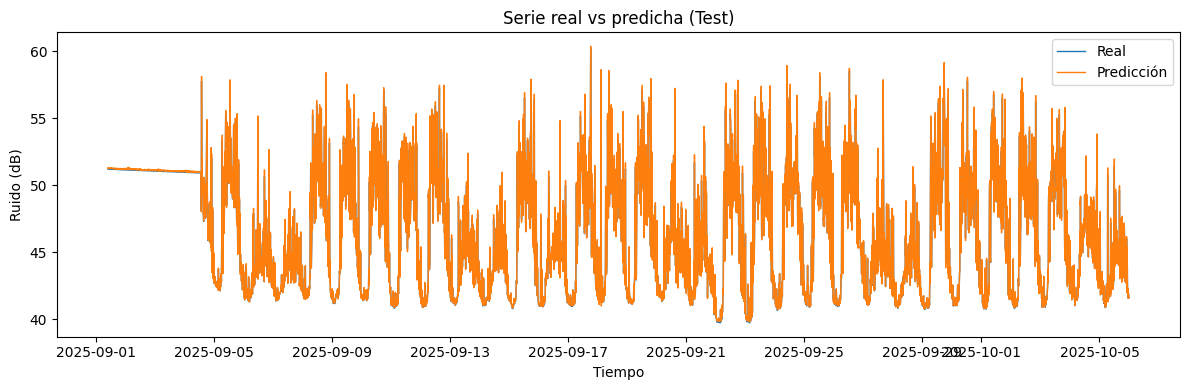

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true_s, y_pred_s = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        yb = yb.to(device).unsqueeze(1)
        pb = model(Xb)
        y_true_s.append(yb.detach().cpu().view(-1).numpy())
        y_pred_s.append(pb.detach().cpu().view(-1).numpy())

y_true_s = np.concatenate(y_true_s)
y_pred_s = np.concatenate(y_pred_s)

# Desescalar a unidades reales (dB)
y_true = scaler_y.inverse_transform(y_true_s.reshape(-1, 1)).ravel()
y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print("===== Métricas de Test (escala real) =====")
print(f"MSE : {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"R²  : {r2:.6f}")

# Alinear con timestamps del split (target de cada ventana está en idx i+SEQ_LEN)
if "timestamp" in df.columns:
    ts_test = df.loc[split_idx + SEQ_LEN : split_idx + SEQ_LEN + len(y_true) - 1, "timestamp"].reset_index(drop=True)
else:
    ts_test = pd.Series(range(len(y_true)), name="timestep")

df_pred = pd.DataFrame({"timestamp": ts_test, "y_true": y_true, "y_pred": y_pred})
df_pred.to_csv("predicciones_test.csv", index=False)
print("✅ Predicciones guardadas en predicciones_test.csv")
display(df_pred.head())

plt.figure(figsize=(12,4))
plt.plot(df_pred["timestamp"], df_pred["y_true"], label="Real", linewidth=1)
plt.plot(df_pred["timestamp"], df_pred["y_pred"], label="Predicción", linewidth=1)
plt.title("Serie real vs predicha (Test)")
plt.xlabel("Tiempo"); plt.ylabel("Ruido (dB)")
plt.legend(); plt.tight_layout(); plt.show()
